<b> This code implements and explain an end to end pipeline of a simple CNN on MNIST dataset. The steps are following:</b> 

1. Loading and preprocessing
2. Defining the CNN model
3. Setting up the loss function and Optimizer 
4. Training the Model
5. Evaluating the test data
6. Making predictions on new data 


In [1]:
pip install torchvision


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
from torchvision import transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
# Set device GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Setup preprocessing for dataset to convert numpy array of pixels to 
# tensor for easier processing which includes transforming to tensors 
# normalizing the pixel values in the range for easier convergence 

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, ), (0.5, ))])


### Let's visualize the images before and after the tranform 

In [4]:
# Downloading MNIST dataset with and without transform
mnist_original = datasets.MNIST(root='./data', train=True, download=True)
mnist_tranformed = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [5]:
# Take a sample image and its label 
index = 0 
original_image, label = mnist_original[index]
transformed_image, _ = mnist_tranformed[index]
# Convert the transformed image from tensor to numpy for visualization
# squeeze() removes the channel dimension  
transformed_image_np = transformed_image.squeeze().numpy()

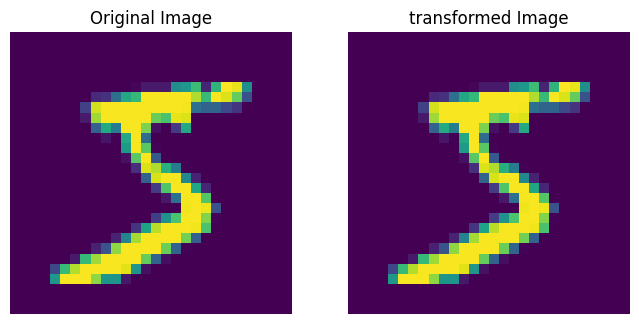

In [6]:
# Plot the images 
fig, axs = plt.subplots(1,2, figsize=(8,4))

#original image 
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[0].axis("off")

#transformed Image 
axs[1].imshow(transformed_image_np)
axs[1].set_title("transformed Image")
axs[1].axis("off")

plt.show()

In [7]:
# The normalization effect can witnessed by printing both 
# images and their pixel values 
original_image_np = np.array(original_image)
print("Pixel Values:\n", original_image_np)
transformed_image_np

Pixel Values:
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.    

In [8]:
# Load dataset with transformations
def get_data_loaders(batch_size=32):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST("./data", train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST("./data", train=False, transform=transform), batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [9]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        # First convolution layer 
        # Why in_channels=1? Because MNIST images are grayscale (single channel)
        # Why padding=1? To maintain the spatial dimensions after convolution
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.ReLU()
        #The pooling window is 2x2, meaning it will look at a 2x2 grid of values at a time.
        #The stride controls how much the window shifts each time. 
        # With a stride of 2, the window will move 2 pixels at a time, meaning it will not overlap with its previous position.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) 

        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer with 10 classes 

    def forward(self, x): 
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = self.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.fc2(x)  # Output layer
        return x
    
    
model = CNN_MNIST().to(device)

In [22]:
# 4. Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set model to training mode, this is a built in method in torch.nn
    # model.train() informs torch to switch the model for training which is essential 
    # for certain operations such as batch normalization or drop out 
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            
            optimizer.zero_grad()  # Flushes the gradients from previous batch
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss by comparing the 10 raw values 
            #returned for each training sample in the outputs 
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            #Extract loss value from the tensor
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
# Evaluate function
def evaluate(model, test_loader, device):
    # This is particularly important for layers that behave differently during training and 
    # inference, such as dropout and batch normalization.
    #Dropout layers, which randomly set some of the units to zero during training to prevent 
    # overfitting, will no longer drop any units when the model is in evaluation mode. 
    # Instead, they will use the full set of activations. Batch normalization layers, which 
    # normalize activations during training based on the current batch statistics (mean and 
    # variance), will instead use running statistics accumulated during training when in 
    # evaluation mode. This ensures more stable predictions during inference.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): #Disables gradient tracking inside the with block.
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #This function returns the maximum value along
            #the specified dimension (dimension 1, which is the class dimension here).
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

In [18]:
# Initialize model, loss function, and optimizer
model = CNN_MNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Load data
train_loader, test_loader = get_data_loaders()

In [23]:
# Train and evaluate
train_model(model, train_loader, criterion, optimizer)
evaluate(model, test_loader, device)

Epoch 1/5, Loss: 0.0691
Epoch 2/5, Loss: 0.0385
Epoch 3/5, Loss: 0.0273
Epoch 4/5, Loss: 0.0207
Epoch 5/5, Loss: 0.0160
Test Accuracy: 0.9900


In [ ]:
### Explain about in_channels and out_channels which are features 
### Explain about how stride moves the filters
### Explain convolution and pooling 
### Explain about the channels, why channels remain the same spatial dimensions are reduced 